In [2]:
from tqdm import tqdm
from typing import List, Dict
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from flowprintOptimal.sekigo.core.flowRepresentation import FlowRepresentation,PacketFlowRepressentation
from flowprintOptimal.sekigo.dataAnalysis.vNATDataFrameProcessor import VNATDataFrameProcessor
from flowprintOptimal.sekigo.core.flowConfig import FlowConfig
import random
from sklearn.model_selection import train_test_split
from flowprintOptimal.sekigo.flowUtils.commons import normalizePacketRep
import os
from flowprintOptimal.sekigo.flowUtils.commons import saveFlows,loadFlows
from flowprintOptimal.sekigo.dataAnalysis.dataFrameProcessor import UTMobileNetProcessor
from flowprintOptimal.sekigo.flowUtils.flowDatasets import DDQNActivityDataset

In [3]:
flows = loadFlows(path= "data/unibs/unibs.json", cls= PacketFlowRepressentation)
flows = list(filter(lambda x : len(x) >= 20,flows))
#print(pd.Series(map(lambda x : x.class_type,flows)).value_counts())
#keep_class = set(["firefox-bin ", "Safari", "Mail", "Transmission","amule", "Skype","firefox"])
packet_flow_reps = flows
#packet_flow_reps = list(filter(lambda x : x.class_type in keep_class, packet_flow_reps))
def assignUNibsClass(class_type):
    class_type = class_type.lower().strip()
    if class_type in ["amule","transmission", "bittorrent.exe"]:
        return "P2P"
    elif class_type in ["mail","thunderbird.exe"]:
        return "MAIL"
    elif class_type in ["skype", "skype"]:
        return "Skype"
    elif class_type in ["safari", "firefox-bin", "opera","safari webpage p", "safari webpage"]:
        return "BROWSERS"
    else:
        return "OTHER"
for packet_flow_rep in packet_flow_reps:
    packet_flow_rep.class_type = assignUNibsClass(class_type= packet_flow_rep.class_type)

pd.Series(map(lambda x : x.class_type,packet_flow_reps)).value_counts()

BROWSERS    19779
P2P         14315
MAIL         4432
OTHER        2558
Skype         633
Name: count, dtype: int64

In [2]:
flows = loadFlows(path= "data/UTMobileNet2021/mobilenetPacketRep.json", cls= PacketFlowRepressentation)
keep_class = set(["facebook","gmail", "google-drive", "google-maps","hangout","instagram","messenger","netflix", "pinterest", "reddit", "spotify","twitter", "youtube"])
packet_flow_reps = flows
packet_flow_reps = list(filter(lambda x : x.class_type in keep_class, packet_flow_reps))
pd.Series(map(lambda x : x.class_type,packet_flow_reps)).value_counts()

google-maps     3256
netflix         2081
reddit          1609
facebook        1312
youtube         1309
pinterest       1233
instagram       1222
spotify          878
google-drive     877
twitter          847
gmail            511
hangout          426
messenger        411
Name: count, dtype: int64

In [2]:
packet_flow_reps = VNATDataFrameProcessor.getPacketFlows()
packet_flow_reps = VNATDataFrameProcessor.convertLabelsToTopLevel(flows= packet_flow_reps)

In [4]:
def convertToFlowRep(packet_flow_rep,grain,band_thresholds):
    inter_arrival_times = packet_flow_rep.inter_arrival_times
    timestamps = [0]
    C = np.log(900000)
    base_time = datetime.datetime(year= 2023, month= 7, day= 31)
    for i in range(1,len(inter_arrival_times)):
        this_timestamp = timestamps[i-1] + np.exp(inter_arrival_times[i]*C) - 1
        timestamps.append(this_timestamp)

    for i in range(len(timestamps)):
        timestamps[i] = base_time + datetime.timedelta(microseconds= float(np.round(timestamps[i])))


    aggregated =  VNATDataFrameProcessor.aggregateByTimeBins(grain= datetime.timedelta(seconds= grain),normalized_timestamps= timestamps,direction= packet_flow_rep.directions,
                                               packet_sizes= packet_flow_rep.lengths,band_thresholds= band_thresholds)

    keys = list(aggregated.keys())
    keys.sort()
    sorted_values = [aggregated[i] for i in keys]
    up_bytes,down_bytes,up_packets,down_packets = [],[],[],[]

    for values in sorted_values:
        up_packets.append(values["up_packets"])
        down_packets.append(values["down_packets"])
        up_bytes.append(values["up_bytes"])
        down_bytes.append(values["down_bytes"])


    up_bytes,down_bytes,up_packets,down_packets = np.array(up_bytes).T,np.array(down_bytes).T,np.array(up_packets).T,np.array(down_packets).T
    return FlowRepresentation(up_bytes= up_bytes, down_bytes= down_bytes, up_packets= up_packets,down_packets= down_packets,
                              class_type= packet_flow_rep.class_type,flow_config= FlowConfig(grain=grain, band_thresholds= band_thresholds)
                              )

In [5]:
timeslot_flow_reps = []
for i in tqdm(range(len(packet_flow_reps))):
    timeslot_rep  = convertToFlowRep(packet_flow_rep= packet_flow_reps[i],grain= .5, band_thresholds= [1250])
    if len(timeslot_rep) >= 20:
        timeslot_flow_reps.append(timeslot_rep.getSubFlow(start_index= 0, length= 20))
    else:
        continue

100%|██████████| 41717/41717 [12:53<00:00, 53.94it/s]  


100%|██████████| 33711/33711 [05:23<00:00, 104.34it/s] 


In [33]:
timeslot_flow_reps = VNATDataFrameProcessor.convertToFlowRepresentations(flow_config= FlowConfig(grain= .5,band_thresholds= [1250]))
timeslot_flow_reps = list(filter(lambda x : len(x) >= 20, timeslot_flow_reps))
timeslot_flow_reps = list(map(lambda x : x.getSubFlow(0,20),timeslot_flow_reps))
timeslot_flow_reps =  VNATDataFrameProcessor.convertLabelsToTopLevel(flows= timeslot_flow_reps)

In [6]:
pd.Series(map(lambda x : x.class_type,timeslot_flow_reps)).value_counts()

P2P         14112
BROWSERS    13976
OTHER        1845
Skype         615
MAIL          355
Name: count, dtype: int64

In [7]:
labels = list(map(lambda x : x.class_type,timeslot_flow_reps))

In [8]:
train_flows,test_flows,train_labels,test_labels = train_test_split(timeslot_flow_reps,labels,test_size= .2)

In [9]:
pd.Series(test_labels).value_counts()

BROWSERS    2814
P2P         2788
OTHER        369
Skype        130
MAIL          80
Name: count, dtype: int64

In [10]:
train_dataset = DDQNActivityDataset(flows= train_flows,label_to_index= None)
test_dataset = DDQNActivityDataset(flows= test_flows,label_to_index= train_dataset.label_to_index)

In [11]:
from flowprintOptimal.sekigo.modeling.trainers import NNClassificationTrainer
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMNetwork,TransformerGenerator,CNNNetwork1D
from flowprintOptimal.sekigo.modeling.loggers import Logger
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [43]:
classifier_ = CNNNetwork1D(in_channels= 6,num_filters= 64,output_dims= [len(train_dataset.label_to_index)],num_layers= 4)#LSTMNetwork(lstm_hidden_size= 64,lstm_input_size=6,output_dim = len(all_train_dataset.label_to_index))
#classifier_ = LSTMNetwork(lstm_input_size= 3,lstm_hidden_size= 128,output_dim= len(train_dataset.label_to_index))
logger= Logger(name= "classification",verbose= True)
logger.default_step_size = 500
classification_trainer = NNClassificationTrainer(classifier = classifier_,device= device,logger= logger)
classification_trainer.train(train_dataset= train_dataset,test_dataset= test_dataset,epochs=200,batch_size= 64,lr= .0001,use_balanced_sampler= True)

classification ---- 1 metric test_f1 = 0.08267716535433071
classification ---- 1 metric test_accuracy = 0.19811320754716982
classification ---- 1 metric train_accuracy = 0.17621293800539084
classification ---- 1 metric train_f1 = 0.07490690346605557
classification ---- 10 metric train_loss = 1.383901059627533
classification ---- 20 metric train_loss = 1.3735269069671632
classification ---- 30 metric train_loss = 1.3618366599082947
classification ---- 40 metric train_loss = 1.3293136477470398
classification ---- 50 metric train_loss = 1.2505483984947205
classification ---- 60 metric train_loss = 1.0707031071186066
classification ---- 70 metric train_loss = 0.915131402015686
classification ---- 80 metric train_loss = 0.8499157965183258
classification ---- 90 metric train_loss = 0.7824710369110107
classification ---- 100 metric train_loss = 0.8162100732326507
classification ---- 110 metric train_loss = 0.7767880976200103
classification ---- 120 metric train_loss = 0.7795724689960479
class

KeyboardInterrupt: 

In [12]:
from flowprintOptimal.sekigo.earlyClassification.DQL.core import MemoryElement,Rewarder,State
from flowprintOptimal.sekigo.earlyClassification.DQL.datasets import MemoryDataset
from flowprintOptimal.sekigo.earlyClassification.DQL.trainers import EarlyClassificationtrainer
import warnings
warnings.filterwarnings('ignore')

In [13]:
class Rewarder:
    def __init__(self,max_length,l,num_labels : int):
        self.max_length = max_length
        self.l = l # l is smaller than 1
        self.num_labels = num_labels

    def reward(self,state : State,action : int):
        if state.label == action:
            # reward 1 on a correct prediction
            return 1, True
        else:
            # either incorrect or wait
            # wait 
            # treat the wait action with a negative reward
            if action == self.num_labels:
                if state.length == self.max_length:
                    # it is the last timestamp
                    if state.label == -1:
                        assert False
                        return 0, True
                    else:
                        return -1,True#self.l*(state.length/self.max_length),True
                else:
                    if state.label == -1:
                        assert False
                        return 0, False
                    else:
                        return -self.l*(state.length/self.max_length), False
            else:
                # incorrect
                return -1,True

In [14]:
class MemoryFiller:
    def __init__(self,dataset,rewarder : Rewarder,min_length : int,max_length):
        self.dataset = dataset
        self.rewarder = rewarder

        self.min_length = min_length
        self.max_length = max_length

        self.actions = list(self.dataset.label_to_index.values())  
        self.actions.append(len(self.actions))

    def processSingleSample(self,data):
        flow, label = data["data"], data["label"]
        memory_elements : List[MemoryElement] = []
        for length in range(self.min_length, self.max_length+1):
            for action in self.actions:
                state = State(timeseries= flow,label= label,length= length)
                reward, terminate = self.rewarder.reward(state= state,action= action)
                
                next_state = State(timeseries= flow,label= label,length= length + 1)
                if terminate == True:
                    # I am reducing the length as I will ahve to pass the state to LSTM 
                    # So I instead of filtering I will just zero all terminal states later.
                    next_state.length -= 1
                    next_state.setTerminal()

                
                memory_element = MemoryElement(state= state,action= action,reward= reward,next_state= next_state)
                memory_elements.append(memory_element)
        return memory_elements
    def processDataset(self):

        memory_elements = []
        
        for i in range(1,len(self.dataset)+1):
            data = self.dataset[i-1]
            memory_elements.extend(self.processSingleSample(data))
 
        return memory_elements

In [15]:
max_length = 20
rewarder = Rewarder(max_length= max_length,l= .1,num_labels= len(train_dataset.label_to_index))
memory_filler = MemoryFiller(dataset= train_dataset,rewarder= rewarder, min_length= 5, max_length= max_length)

In [16]:
memory = memory_filler.processDataset()
print(len(memory))

2373312


In [17]:
memory_dataset = MemoryDataset(memories= memory,num_classes= len(train_dataset.label_to_index), corrupt_prob= 0,
                               min_length= memory_filler.min_length,max_length= memory_filler.max_length)
predictor = LSTMNetwork(lstm_input_size= 6,lstm_hidden_size= 256,output_dim= len(train_dataset.label_to_index) + 1)
logger = Logger(verbose= True)
logger.default_step_size = 1000

In [18]:
ddq_model = EarlyClassificationtrainer(predictor= predictor,train_dataset = train_dataset,test_dataset= test_dataset,memory_dataset= memory_dataset,
                                       ood_dataset= test_dataset,
                                       logger= logger,device=device,model_replacement_steps= 100)

In [19]:
ddq_model.train(epochs= 25,batch_size= 128,model_lag_in_steps= 100,lr= .0005)

 ---- 1000 metric loss = 0.277944629073143
 ---- 1 metric test_eval_f1 = 0.8040770101925255
 ---- 1 metric test_eval_time = 7.1755379388448475
 ---- 1 metric ood_eval = 0.0
 ---- 1 metric ood_eval_time = 7.1755379388448475
 ---- 2000 metric loss = 0.21906021643429996
 ---- 2 metric test_eval_f1 = 0.8099013104675619
 ---- 2 metric test_eval_time = 13.022811842743893
 ---- 2 metric ood_eval = 0.0
 ---- 2 metric ood_eval_time = 13.022811842743893
 ---- 1 metric train_eval_f1 = 0.8132432651080009
 ---- 1 metric train_eval_time = 12.991869589839009
 ---- 3000 metric loss = 0.20469975847750901
 ---- 3 metric test_eval_f1 = 0.812651674486329
 ---- 3 metric test_eval_time = 6.179906164051125
 ---- 3 metric ood_eval = 0.0
 ---- 3 metric ood_eval_time = 6.179906164051125
 ---- 4000 metric loss = 0.19693738949671388
 ---- 4 metric test_eval_f1 = 0.8207409804238797
 ---- 4 metric test_eval_time = 6.45931079113412
 ---- 4 metric ood_eval = 0.0
 ---- 4 metric ood_eval_time = 6.45931079113412
 ---- 2

KeyboardInterrupt: 

In [22]:
np.argmax(np.array(logger.getMetric(metric_name= "test_eval_f1")))
print(logger.getMetric(metric_name= "test_eval_time")[136])
logger.getMetric(metric_name= "test_eval_f1")[136]

7.261122795664132


0.928328749393302

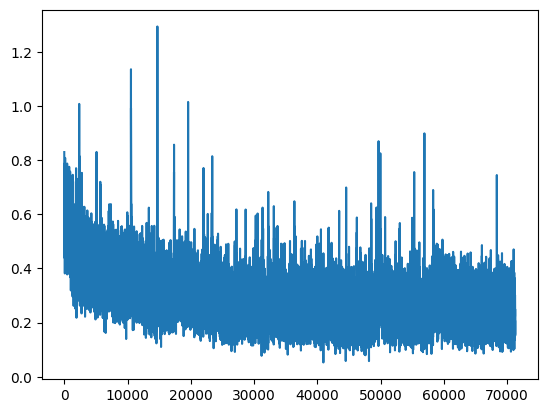

In [30]:
plt.plot(logger.getMetric(metric_name= "loss"))

In [29]:
logger.getAllMetricNames()

['loss',
 'test_eval_f1',
 'test_eval_time',
 'ood_eval',
 'ood_eval_time',
 'train_eval_f1',
 'train_eval_time']